In [1]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})


import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
allensdk.__version__
import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

In [22]:
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

# Functions

In [26]:


def crossValidateLinearModel(X, y , n_split = 5, shuffle = False, shuffle_seed = None):
    '''
    Cross validate a linear model using KFold cross validation

    Parameters
    ----------
    X : np.array
        The input data to fit
    y : np.array
        The output data to fit
    n_split : int
        The number of splits to use
    shuffle : bool
        Whether or not to shuffle the data
    shuffle_seed : int
        The seed to use for shuffling the data

    Returns
    -------
    Mean Score: float
        The average cross validation score
    Model List: list    
        The models fit to each fold of the data
    Test score: np.array    
        The cross validation scores for testing data each fold
    Train score: np.array
        The cross validation scores for testing data each fold
    '''

    if len(X.shape)==1:
        X = X.copy().reshape(-1,1)
    # Initialize KFold object
    folderizer = KFold(n_splits=n_split,shuffle=shuffle,random_state=shuffle_seed)
    # Create an array to save the results
    self_score = np.empty(n_split)
    cross_score = np.empty(n_split)
    models = [None]*n_split
    # Loop through the folds, fit the model, and save the results
    for ii, (train_index, test_index) in enumerate(folderizer.split(X,y)):
        models[ii] = LinearRegression(fit_intercept=False).fit(X[train_index,:], y[train_index])
        self_score[ii] = models[ii].score(X[train_index,:], y[train_index])
        cross_score[ii] = models[ii].score(X[test_index,:], y[test_index])
        
    return np.mean(cross_score), models,cross_score,self_score


# Load the natural movie

+ https://observatory.brain-map.org/visualcoding/stimulus/natural_movies
+ https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html#behavioral-training

In [3]:
movie_path = r"/allen/programs/braintv/workgroups/neuralcoding/Saskia/Visual Stimuli 151207/Movie_TOE1.npy"
movie = np.load(movie_path)
print(f"Movie shape: {movie.shape}")

Movie shape: (900, 304, 608)


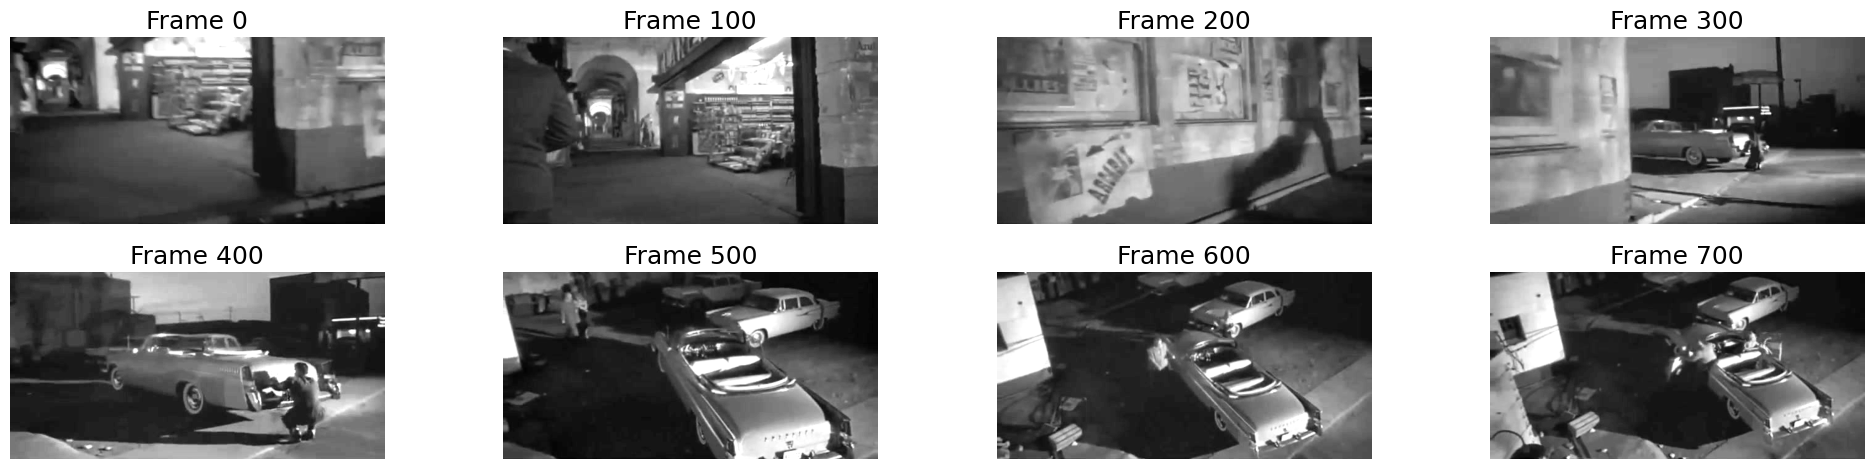

In [4]:

fig, ax = plt.subplots(2,4,figsize=(20, 5))
ax = ax.ravel()
# shwo every 100 frames on subplot
for i in range(8):
    ax[i].imshow(movie[100*i], cmap='gray')
    ax[i].set_title(f"Frame {100*i}")
    ax[i].axis('off')
plt.tight_layout()


# Get neural data

Mice: 24
['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt']
cre_line           mouse_id
Slc17a7-IRES2-Cre  453911      11
                   451787       8
                   547486       8
                   456915       6
                   479839       6
                   484627       6
                   485152       6
                   541329       6
                   547266       6
Sst-IRES-Cre       482853       9
                   457841       8
                   440631       7
                   448366       6
                   544965       6
                   546605       5
Vip-IRES-Cre       435431       9
                   453990       9
                   438912       6
                   453988       6
                   453989       6
                   453991       6
                   523922       6
                   449653       5
                   528

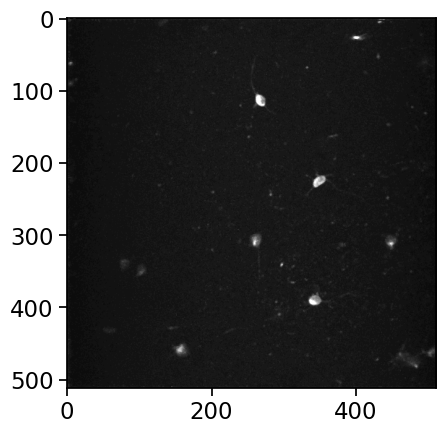

In [5]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

output_dir = r'/swdb2024_data_cache'
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=output_dir)

behavior_session_table = cache.get_behavior_session_table()  
ophys_session_table = cache.get_ophys_session_table()   
ophys_experiment_table = cache.get_ophys_experiment_table()    
ophys_cells_table = cache.get_ophys_cells_table()


project_code = 'VisualBehaviorMultiscope'
multiscope_sessions = ophys_session_table[ophys_session_table.project_code==project_code]

print(f"Mice: {len(multiscope_sessions.mouse_id.unique())}")
print(multiscope_sessions.full_genotype.unique())
print(multiscope_sessions.groupby("cre_line").mouse_id.value_counts())

# mouse + sessions
mouse_id = '546605' # SST
sessions = ophys_session_table[(ophys_session_table.mouse_id==mouse_id) & 
                                (ophys_session_table.session_type=='OPHYS_1_images_A')]

# experiment
ophys_experiment_id = 1080945462
dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id)

plt.imshow(dataset.max_projection, cmap='gray')

# stim presentations
stimulus_presentations = dataset.stimulus_presentations.copy()
stimulus_presentations = stimulus_presentations[stimulus_presentations.stimulus_block_name=='change_detection_behavior']
print(stimulus_presentations.stimulus_block_name.unique())
print(stimulus_presentations.image_name.unique())

# pick cell
cell_specimen_id = 1120091421

# Get movie related calcium traces


In [6]:
stimulus_presentations = dataset.stimulus_presentations.copy()
movie_presentations = stimulus_presentations[stimulus_presentations.stimulus_block_name=='natural_movie_one']

Note the number of times the movie was presented to the mice by showing unique values in the movie repeats column.

In [7]:
movie_presentations.movie_repeat.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
repeat_0 = movie_presentations[movie_presentations.movie_repeat==0]
print(f"Number of frames: {len(repeat_0)}")

Number of frames: 900


In [10]:
repeat_0.duration

stimulus_presentations_id
4808    0.03336
4809    0.03333
4810    0.03337
4811    0.03336
4812    0.03336
         ...   
5703    0.03335
5704    0.03337
5705    0.03336
5706    0.03335
5707    0.03338
Name: duration, Length: 900, dtype: float64

In [11]:
# ~ 30hz
rate = 1/ repeat_0.duration.iloc[0]
print(f"Frame rate: {rate}")

Frame rate: 29.9760191843314


So we have around 30hz x 900 frames = 30 second movie

### Get the start time of each movie

In [9]:
dataset.stimulus_presentations['new_column'] = 0
dataset.stimulus_presentations.columns

Index(['stimulus_block', 'stimulus_block_name', 'image_index', 'image_name',
       'movie_frame_index', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'movie_repeat', 'flashes_since_change', 'trials_id', 'active',
       'stimulus_name', 'is_sham_change'],
      dtype='object')

In [13]:
dataset.stimulus_presentations

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
0,0,initial_gray_screen_5min,-99,NaN,-99,309.366891,0.000000,309.366891,0,17985,False,<NA>,<NA>,-99,0,-99,False,spontaneous,False
1,1,change_detection_behavior,0,im065,-99,0.250210,309.366891,309.617101,17985,18000,False,False,False,-99,1,0,True,Natural_Images_Lum_Matched_set_training_2017,False
2,1,change_detection_behavior,0,im065,-99,0.250220,310.117501,310.367721,18030,18045,False,False,False,-99,2,0,True,Natural_Images_Lum_Matched_set_training_2017,False
3,1,change_detection_behavior,0,im065,-99,0.250190,310.868141,311.118331,18075,18090,False,False,False,-99,3,0,True,Natural_Images_Lum_Matched_set_training_2017,False
4,1,change_detection_behavior,0,im065,-99,0.250200,311.618751,311.868951,18120,18135,False,False,False,-99,4,0,True,Natural_Images_Lum_Matched_set_training_2017,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13803,3,natural_movie_one,-99,NaN,895,0.033360,4517.471281,4517.504641,270262,270263,False,<NA>,<NA>,9,9002,-99,False,natural_movie_one,False
13804,3,natural_movie_one,-99,NaN,896,0.033360,4517.504641,4517.538001,270264,270265,False,<NA>,<NA>,9,9003,-99,False,natural_movie_one,False
13805,3,natural_movie_one,-99,NaN,897,0.033350,4517.538001,4517.571351,270266,270267,False,<NA>,<NA>,9,9004,-99,False,natural_movie_one,False


In [10]:
# get movie_frame_index ==0 
movie_starts = movie_presentations[movie_presentations.movie_frame_index==0]
movie_starts

,stimulus_block,stimulus_block_name,image_index,image_name,movie_frame_index,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,movie_repeat,flashes_since_change,trials_id,active,stimulus_name,is_sham_change
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,
4808,3,natural_movie_one,-99,NaN,0,0.03336,4217.392861,4217.426221,252272,252273,False,<NA>,<NA>,0,7,-99,False,natural_movie_one,False
5708,3,natural_movie_one,-99,NaN,0,0.03336,4247.417371,4247.450731,254072,254073,False,<NA>,<NA>,1,907,-99,False,natural_movie_one,False
6608,3,natural_movie_one,-99,NaN,0,0.03334,4277.441891,4277.475231,255872,255873,False,<NA>,<NA>,2,1807,-99,False,natural_movie_one,False
7508,3,natural_movie_one,-99,NaN,0,0.03336,4307.466411,4307.499771,257672,257673,False,<NA>,<NA>,3,2707,-99,False,natural_movie_one,False
8408,3,natural_movie_one,-99,NaN,0,0.03331,4337.490981,4337.524291,259472,259473,False,<NA>,<NA>,4,3607,-99,False,natural_movie_one,False
9308,3,natural_movie_one,-99,NaN,0,0.03336,4367.515471,4367.548831,261272,261273,False,<NA>,<NA>,5,4507,-99,False,natural_movie_one,False
10208,3,natural_movie_one,-99,NaN,0,0.03335,4397.539981,4397.573331,263072,263073,False,<NA>,<NA>,6,5407,-99,False,natural_movie_one,False
11108,3,natural_movie_one,-99,NaN,0,0.03336,4427.564511,4427.597871,264872,264873,False,<NA>,<NA>,7,6307,-99,False,natural_movie_one,False
12008,3,natural_movie_one,-99,NaN,0,0.03337,4457.589021,4457.622391,266672,266673,False,<NA>,<NA>,8,7207,-99,False,natural_movie_one,False


In [11]:
event_times = movie_starts.start_time.values
event_ids = movie_starts.movie_repeat.values

In [12]:
data = data_formatting.build_tidy_cell_df(dataset, exclude_invalid_rois=True)
unique_ids = np.unique(data['cell_specimen_id'].values)

In [13]:
import brain_observatory_utilities.utilities.general_utilities as general_utilities

In [14]:
output_sampling_rate = 30
time_window = [0, 30]
interpolate = True
data_type = 'dff'

# collect aligned data
sliced_dataout = []

# align data using interpolation method
for unique_id in unique_ids:
    etr = general_utilities.event_triggered_response(
        data=data[data['cell_specimen_id'] == unique_id],
        t='timestamps',
        y=data_type,
        event_times=event_times,
        t_start=time_window[0],
        t_end=time_window[1],
        output_format='wide',
        interpolate=interpolate,
        output_sampling_rate=output_sampling_rate
    )

    # get timestamps array
    trace_timebase = etr.index.values

    # collect aligned data from all cell, all trials into one array
    sliced_dataout.append(etr.transpose().values)
sliced_dataout = np.array(sliced_dataout)

# remove the last element of the timebase array and the last element of the data array
trace_timebase = trace_timebase[:-1]
sliced_dataout = sliced_dataout[:, :, :-1]

print(sliced_dataout.shape)

(5, 10, 900)


cell x repeat x time
5 cells, 10 repeats

11 seconds X 30 hz = 330
add 1 for indexing, and we get 331

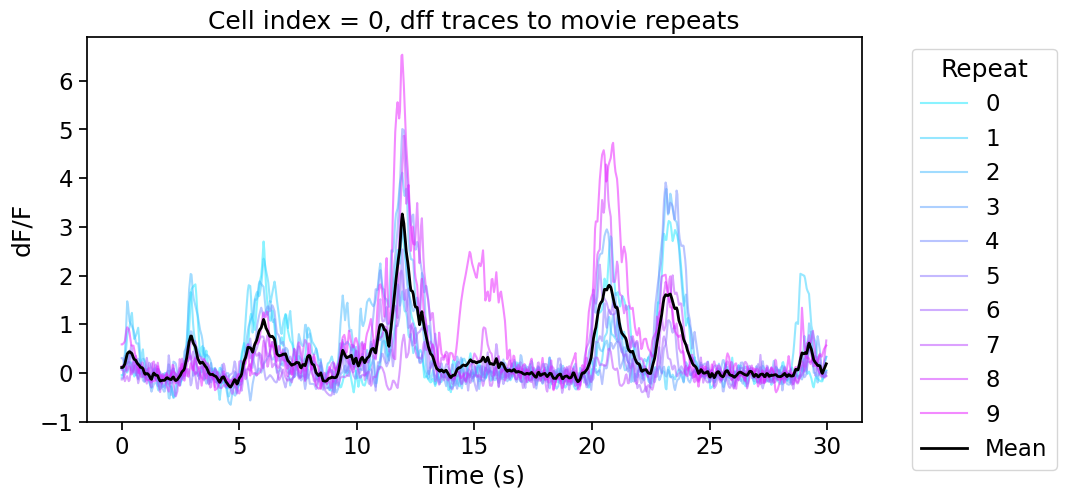

In [15]:
# plot traces for a single cell
cell_index = 0

cell_traces = sliced_dataout[cell_index]
colors = sns.color_palette('cool', n_colors=cell_traces.shape[0])
plt.figure(figsize=(10, 5))
for i in range(cell_traces.shape[0]):
    plt.plot(trace_timebase, cell_traces[i], color=colors[i], alpha=0.5, label=i)
plt.title(f'Cell index = {cell_index}, dff traces to movie repeats')
plt.xlabel('Time (s)')
plt.ylabel('dF/F')

# plot mean
mean_trace = np.mean(cell_traces, axis=0)
# same fig
plt.plot(trace_timebase, mean_trace, color='black', linewidth=2, label='Mean')

# legend title repeats
plt.legend(title='Repeat', bbox_to_anchor=(1.05, 1), loc='upper left')


In [16]:
# get mean response for each cell
cell_mean_traces = np.mean(sliced_dataout, axis=1)
cell_mean_traces.shape

(5, 900)

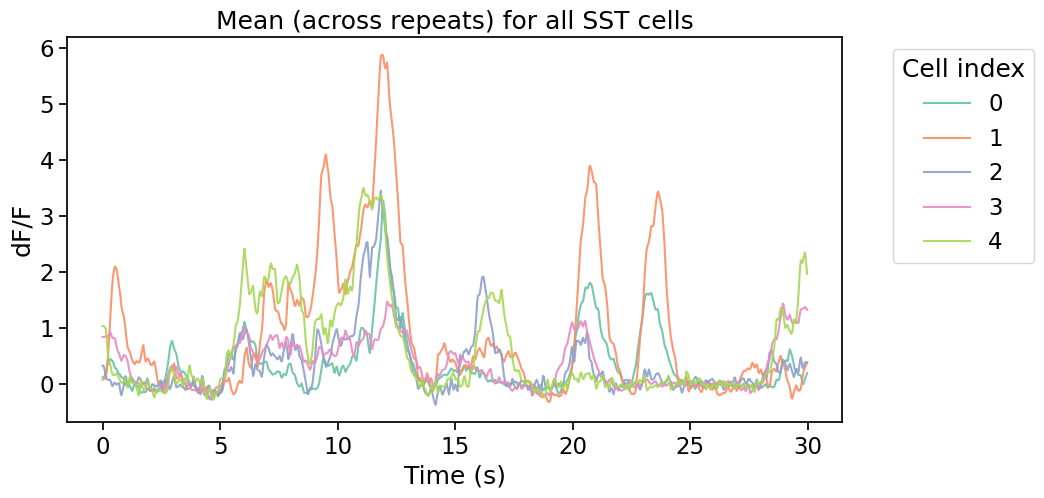

In [17]:
# plot mean traces for all cells
plt.figure(figsize=(10, 5))
colors = sns.color_palette('Set2', n_colors=sliced_dataout.shape[0])

for i in range(cell_mean_traces.shape[0]):
    plt.plot(trace_timebase, cell_mean_traces[i], color=colors[i], alpha=0.9, label=i)
plt.xlabel('Time (s)')
plt.ylabel('dF/F')
# legend for cells
plt.legend(range(sliced_dataout.shape[0]))
plt.title('Mean (across repeats) for all SST cells')

plt.legend(title='Cell index', bbox_to_anchor=(1.05, 1), loc='upper left')

# Extract features from movie

In [18]:
# calculate motion energy between frames
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal

def motion_energy(movie):
    """
    Calculate motion energy between frames
    """
    # calculate motion energy
    motion_energy = np.zeros(movie.shape[0]-1)
    for i in range(movie.shape[0]-1):
        motion_energy[i] = np.sum(np.abs(movie[i+1] - movie[i]))

    # add zero to the end
    motion_energy = np.append(motion_energy, 0)
    return motion_energy


def calc_movie_metrics(movie):

    # calculate motion energy
    me = motion_energy(movie)
    avg = np.mean(movie, axis=(1,2))
    contrast = np.std(movie, axis=(1,2))
    kurtosis = stats.kurtosis(movie, axis=(1,2))

    return me, avg, contrast, kurtosis

me, avg, contrast, kurtosis = calc_movie_metrics(movie)
me_filtered = signal.medfilt(me, kernel_size=7)


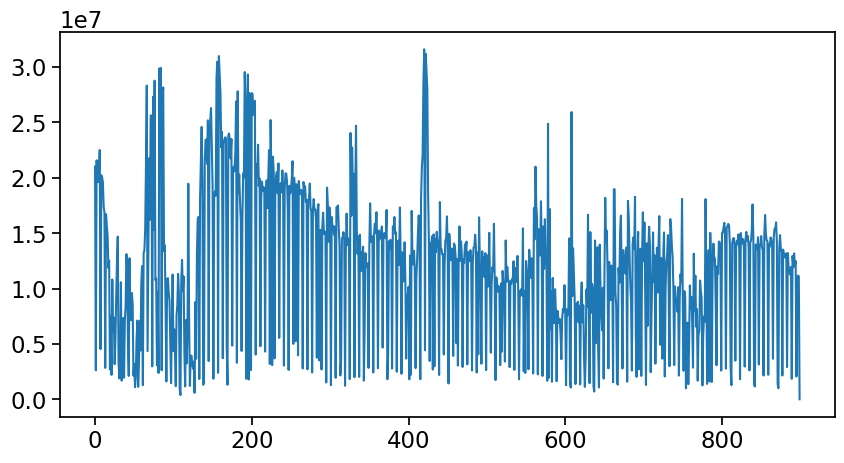

In [19]:
# plot me 
plt.figure(figsize=(10, 5))
plt.plot(me, label='Motion energy')


Text(0, 0.5, 'Motion energy')

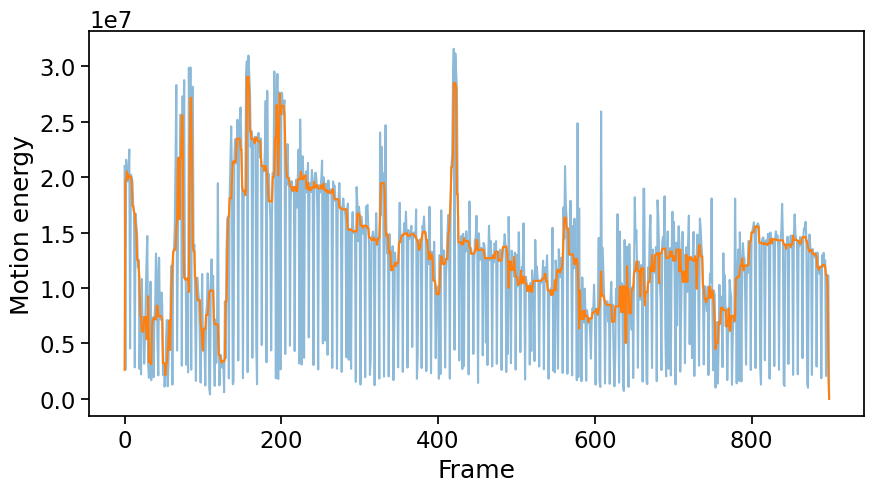

In [20]:
plt.figure(figsize=(10, 5))

plt.plot(me,label='Motion energy', alpha=0.5)
plt.plot(me_filtered, label='Motion energy (filtered)')

plt.xlabel('Frame')
plt.ylabel('Motion energy')



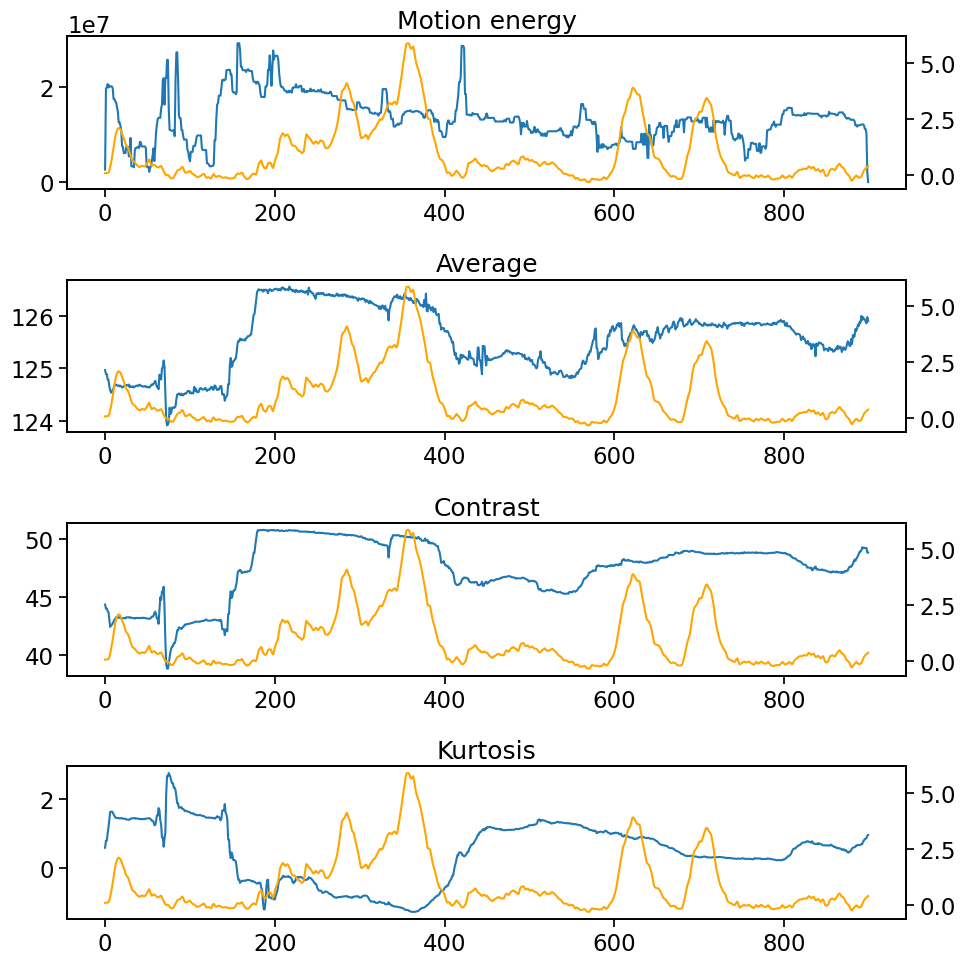

In [21]:
cell_index = 1
cell_trace_to_plot = cell_mean_traces[cell_index]

x_axis_time = np.arange(0, len(cell_trace_to_plot))
#x_axis_time = trace_timebase



fig, axes = plt.subplots(4,1,figsize=(10, 10))
axes = axes.ravel()

axes[0].plot(x_axis_time, me_filtered, label='Motion energy')
axes[0].set_title('Motion energy')

axes[1].plot(x_axis_time, avg, label='Average')
axes[1].set_title('Average')

axes[2].plot(x_axis_time, contrast, label='Contrast')
axes[2].set_title('Contrast')

axes[3].plot(x_axis_time, kurtosis, label='Kurtosis')
axes[3].set_title('Kurtosis')


for ax in axes:
    ax2 = ax.twinx()
    ax2.plot(x_axis_time, cell_trace_to_plot, label='Cell trace', color='orange')

# xlim
plt.tight_layout()


# Linear regression with movie features

## Create stimulus matrix X

In [23]:
X = np.vstack([me_filtered, avg, contrast, kurtosis]).T

# us min max scaler to build X
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Text(0.5, 1.0, 'Scaled movie features')

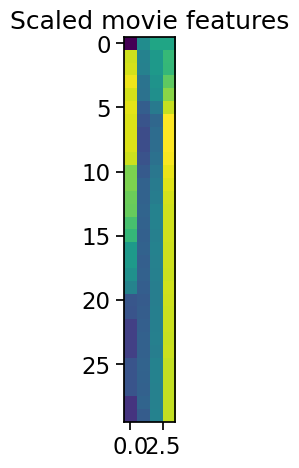

In [24]:
fig, ax = plt.subplots(1,figsize=(5, 5))
plt.imshow(X[:30])
plt.title('Scaled movie features')

In [ ]:
## regression on population mean of single cell

In [ ]:
## regression on population mean of single cell

## Regression on population mean of single cell

In [37]:
cell_index = 0
y = cell_mean_traces[cell_index]

score, models, scores, _ = crossValidateLinearModel(X, y)
print(f"Score: {scores}")

Score: [-3.77266085 -0.53260539  0.27470712 -0.31521838 -7.4907742 ]


Text(0.5, 1.0, 'Reconstruction of cell 0, score: -0.39')

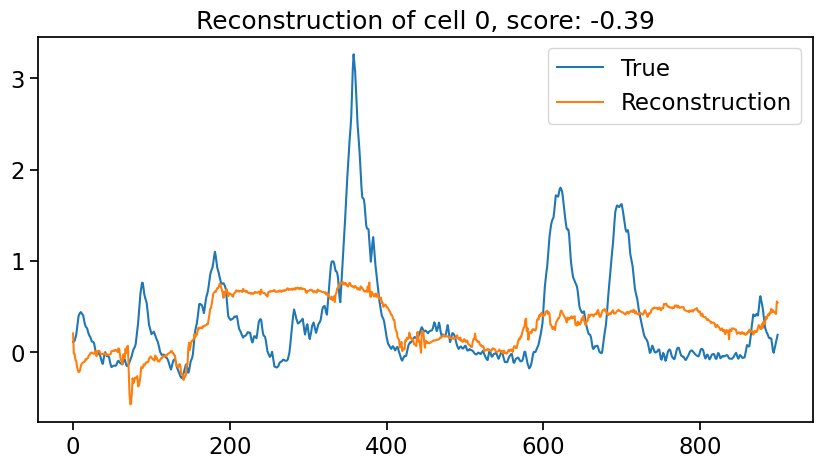

In [35]:
# plot reconstruction
reconstruction = np.zeros_like(y)
for model in models:
    reconstruction += model.predict(X)
    score += model.score(X, y)
reconstruction /= len(models)
score /= len(models)

plt.figure(figsize=(10, 5))
plt.plot(y, label='True')
plt.plot(reconstruction, label='Reconstruction')
plt.legend()
plt.title(f'Reconstruction of cell {cell_index}, score: {score:.2f}')

## Regression on population means of 5 cells

In [31]:
for cell in range(cell_mean_traces.shape[0]):
    y = cell_mean_traces[cell]
    score, models, _, _ = crossValidateLinearModel(X, y)
    print(score)

-2.3673103378510083
-6.051325386902567
-2.4899609071410302
-0.045452581322358944
-11.137937990852945


# LOO

In [38]:
cell_index = 0
cell_dff_repeats = sliced_dataout[cell_index]
print(cell_dff_repeats.shape)

(10, 900)


In [71]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


movie_features = X


loo = LeaveOneOut()
predictions = []
actuals = []
models = []
coefficients = []
intercepts = []

for train_index, test_index in loo.split(cell_dff_repeats):
    # Split the data
    X_train = np.tile(movie_features, (len(train_index), 1))
    y_train = cell_dff_repeats[train_index].flatten()
    X_test = movie_features
    y_test = cell_dff_repeats[test_index].flatten()
    print(f"Train: {X_train.shape}, {y_train.shape}. Test: {X_test.shape}, {y_test.shape}")
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Collect coefficients and intercepts
    coefficients.append(model.coef_)
    intercepts.append(model.intercept_)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Store predictions and actuals
    predictions.append(y_pred)
    actuals.append(y_test)

# Convert lists to arrays
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# Evaluate model performance
mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error: {mse}")

Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Train: (8100, 4), (8100,). Test: (900, 4), (900,)
Mean Squared Error: 0.5393062633287183


shape: (900,), (900,)
Mean Squared Error of Averaged Model: 0.5547199717435338
Averaged Coefficients: [-0.55083098  0.9628919  -0.87636595 -1.03820669]
Averaged Intercept: 1.0543079993077653


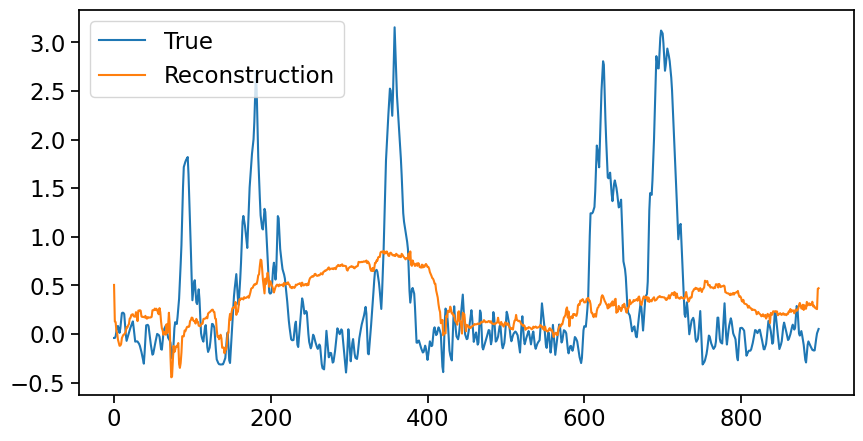

In [79]:
avg_coefficients = np.mean(coefficients, axis=0)
avg_intercept = np.mean(intercepts, axis=0)

average_model = LinearRegression()
average_model.coef_ = avg_coefficients
average_model.intercept_ = avg_intercept

# select 1 repeat
y_all = cell_dff_repeats[0]
X_all = movie_features
y_pred = average_model.predict(X_all)
print(f"shape: {y_all.shape}, {y_pred.shape}")

# Evaluate model performance
mse = mean_squared_error(y_all, y_pred)
print(f"Mean Squared Error of Averaged Model: {mse}")

# Optional: Print the averaged coefficients and intercept
print(f"Averaged Coefficients: {avg_coefficients}")
print(f"Averaged Intercept: {avg_intercept}")

# plot reconstruction
reconstruction = y_pred
score = average_model.score(X_all, y_all)

plt.figure(figsize=(10, 5))
plt.plot(y_all, label='True')
plt.plot(reconstruction, label='Reconstruction')
plt.legend()

In [102]:
from sklearn.preprocessing import PolynomialFeatures
degree = 2

In [100]:
movie_features = X
# Transform features to polynomial features
poly = PolynomialFeatures(degree)
movie_features_poly = poly.fit_transform(movie_features)

loo = LeaveOneOut()
predictions = []
actuals = []
models = []
coefficients = []
intercepts = []

for train_index, test_index in loo.split(cell_dff_repeats):
    # Split the data
    X_train = np.tile(movie_features_poly, (len(train_index), 1))
    y_train = cell_dff_repeats[train_index].flatten()
    X_test = movie_features_poly
    y_test = cell_dff_repeats[test_index].flatten()
    print(f"Train: {X_train.shape}, {y_train.shape}. Test: {X_test.shape}, {y_test.shape}")
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Collect coefficients and intercepts
    coefficients.append(model.coef_)
    intercepts.append(model.intercept_)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Store predictions and actuals
    predictions.append(y_pred)
    actuals.append(y_test)

# Convert lists to arrays
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# Evaluate model performance
mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error: {mse}")

Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Train: (8100, 35), (8100,). Test: (900, 35), (900,)
Mean Squared Error: 0.4543773437768903


shape: (900,), (900,)
Mean Squared Error of Averaged Model: 0.5254159971377291
Averaged Coefficients: [ 1.43021080e+13 -1.26220200e+02 -5.73912059e+01 -4.28926290e+02
 -5.59891261e+02  1.95475283e+01 -1.60834062e+02  3.80381095e+02
  2.06108527e+02 -1.33497491e+00  1.98117288e+02  6.63238715e+01
  1.87679516e+02  7.66471011e+02  5.40712351e+02  3.55915539e+00
  6.49586471e+01 -8.65301313e+01 -1.90855297e+01  1.47967836e+02
 -1.96194568e+02  1.44241954e+02 -4.65826616e+01 -3.07590885e+02
 -8.68021978e+01  9.95221994e+00 -7.05944948e+01 -1.87921446e+01
 -1.48634439e+01 -7.60386317e+01 -3.17773106e+01 -2.49993041e+01
 -2.15859633e+02 -3.49314047e+02 -1.82331188e+02]
Averaged Intercept: -14302107995356.1


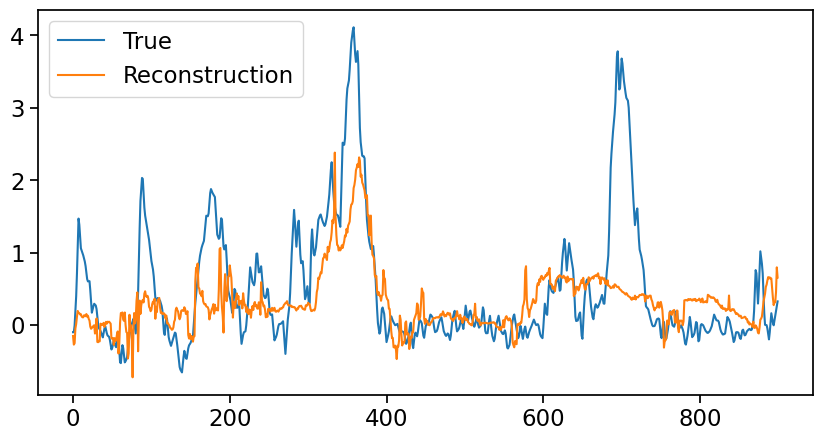

In [101]:
avg_coefficients = np.mean(coefficients, axis=0)
avg_intercept = np.mean(intercepts, axis=0)

average_model = LinearRegression()
average_model.coef_ = avg_coefficients
average_model.intercept_ = avg_intercept

# select 1 repeat
y_all = cell_dff_repeats[2]
X_all = movie_features_poly
y_pred = average_model.predict(X_all)
print(f"shape: {y_all.shape}, {y_pred.shape}")

# Evaluate model performance
mse = mean_squared_error(y_all, y_pred)
print(f"Mean Squared Error of Averaged Model: {mse}")

# Optional: Print the averaged coefficients and intercept
print(f"Averaged Coefficients: {avg_coefficients}")
print(f"Averaged Intercept: {avg_intercept}")

# plot reconstruction
reconstruction = y_pred
score = average_model.score(X_all, y_all)

plt.figure(figsize=(10, 5))
plt.plot(y_all, label='True')
plt.plot(reconstruction, label='Reconstruction')
plt.legend()

## Regression on population mean of single cell

## Regression on population mean of single cell

In [64]:
np.mean(predictions.reshape(n_frames, -1),axis=1).shape

(900,)

(900, 1)


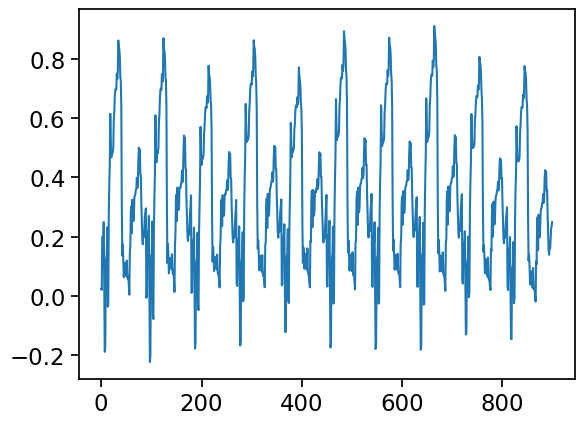

In [53]:
# reshape predictions to 900x10 and avg
n_frames = cell_dff_repeats.shape[1]
predictions = predictions.reshape(n_frames, -1)
print(predictions.shape)
predictions = np.mean(predictions, axis=1)
plt.plot(predictions, label='Predictions')

(0.0, 1.0)

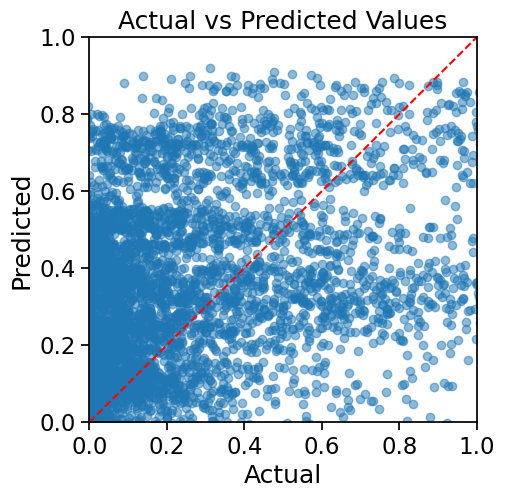

In [45]:
# Plot the actual vs predicted values
plt.figure(figsize=(5, 5))
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
# add 1:1 line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

# Leave one out

In [126]:
cell_index = 0
cell_dff_repeats = sliced_dataout[cell_index]
# cell_dff_repeats.shape

# Y_flat = cell_dff_repeats.flatten()
# Y_flat.shape
Y = cell_dff_repeats
Y.shape


(10, 900)

In [106]:
X_tiled = np.tile(X, (10, 1))
X_tiled.shape

(9000, 4)

In [117]:
train_index, test_index

(array([0, 1, 2]), array([3]))

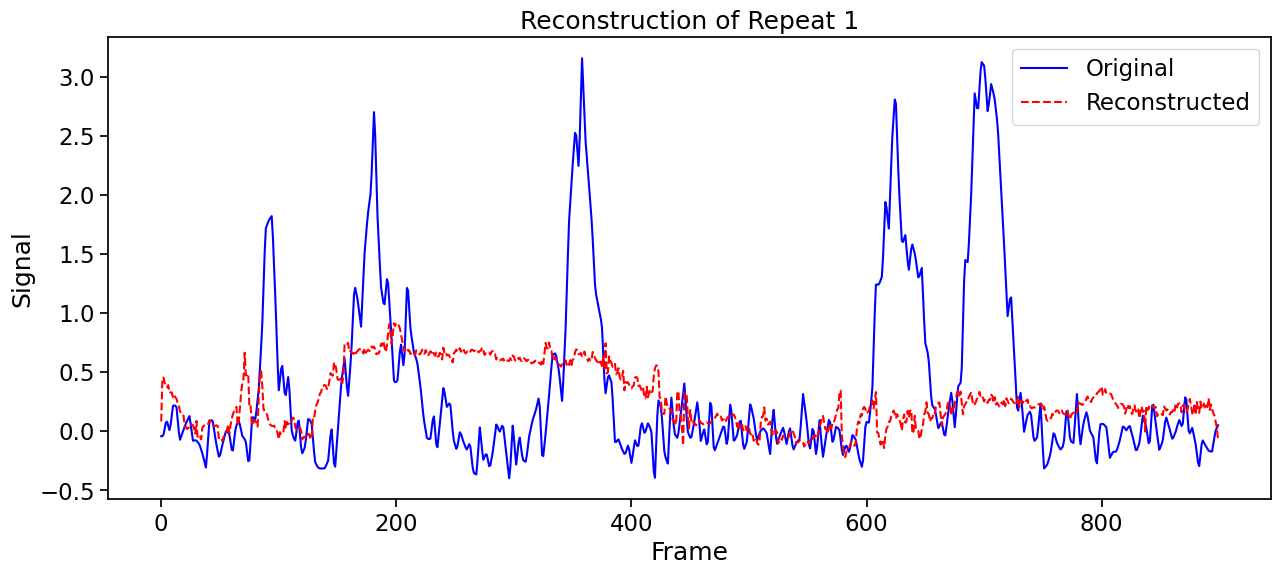

In [124]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Initialize the model and cross-validator

leave_out_index = 0

# Prepare training data by leaving out the selected repeat
X_train = X
Y_train = np.delete(Y, leave_out_index, axis=0).reshape(-1, Y.shape[1]).T

# Prepare test data
Y_test = Y[leave_out_index]

# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, Y_train)

# Predict on the test data
Y_pred = model.predict(X_train)

# Plot the original and reconstructed time series for the target repeat
plt.figure(figsize=(15, 6))
plt.plot(Y_test, label='Original', color='blue')
plt.plot(Y_pred[:, leave_out_index], label='Reconstructed', color='red', linestyle='--')
plt.title(f'Reconstruction of Repeat {leave_out_index + 1}')
plt.xlabel('Frame')
plt.ylabel('Signal')
plt.legend()
plt.show()

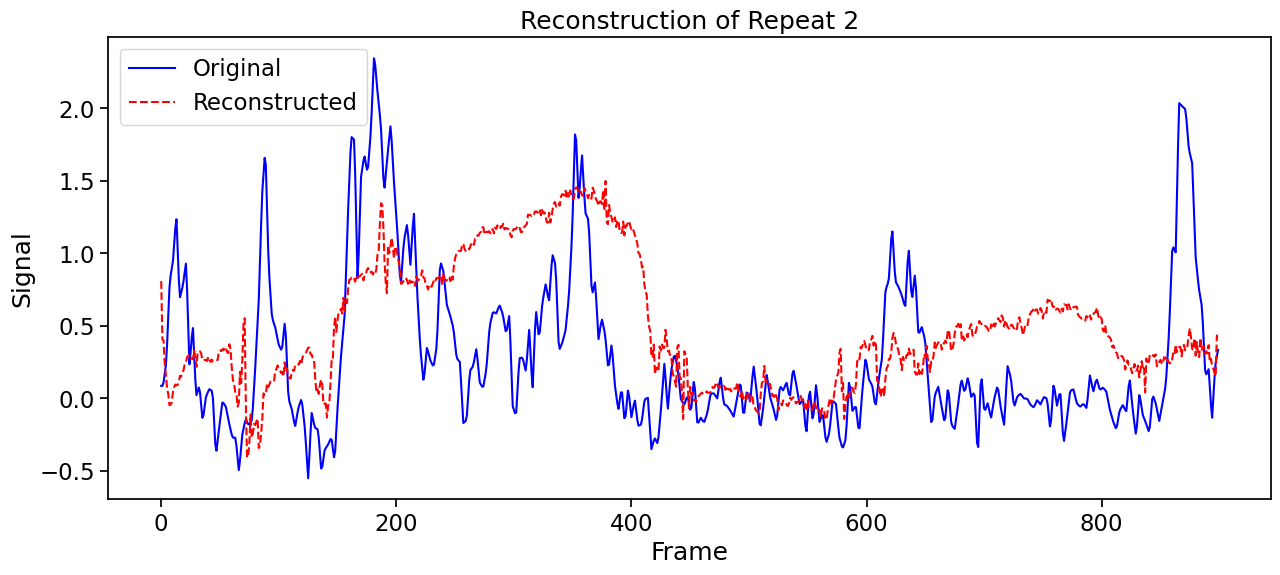

In [123]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Initialize the model and cross-validator

leave_out_index = 1

# Prepare training data by leaving out the selected repeat
X_train = X
Y_train = np.delete(Y, leave_out_index, axis=0).reshape(-1, Y.shape[1]).T

# Prepare test data
Y_test = Y[leave_out_index]

# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, Y_train)

# Predict on the test data
Y_pred = model.predict(X_train)

# Plot the original and reconstructed time series for the target repeat
plt.figure(figsize=(15, 6))
plt.plot(Y_test, label='Original', color='blue')
plt.plot(Y_pred[:, leave_out_index], label='Reconstructed', color='red', linestyle='--')
plt.title(f'Reconstruction of Repeat {leave_out_index + 1}')
plt.xlabel('Frame')
plt.ylabel('Signal')
plt.legend()
plt.show()

In [112]:
predictions

array([-0.02069269, -0.02986921, -0.03875976, ...,  0.        ,
        0.        ,  0.        ])

(8000.0, 9000.0)

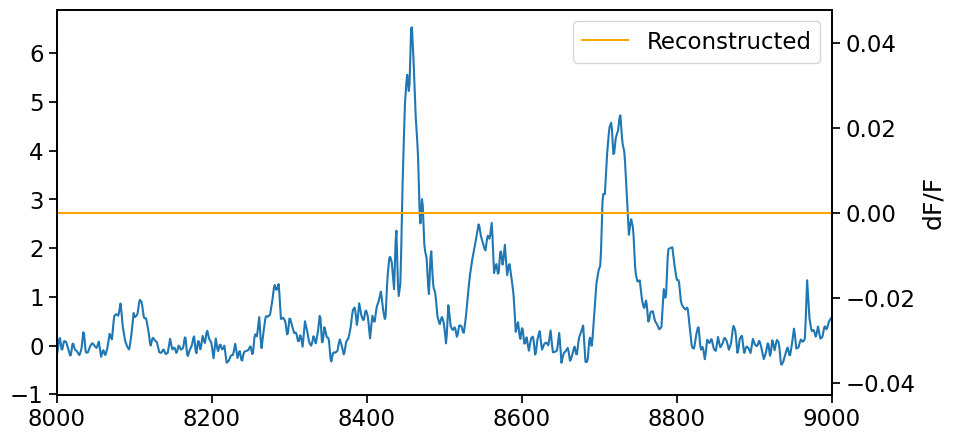

In [115]:
# plot reconstructed vs original
plt.figure(figsize=(10, 5))
plt.plot(Y_flat, label='Original')
# twin x
plt.twinx()
plt.plot(predictions, label='Reconstructed', color='orange')
plt.xlabel('Time')
plt.ylabel('dF/F')
plt.legend()
#xlim
plt.xlim(8000, 9000)
# xlim

## repeats with avg

In [130]:
Y.shape

(10, 900)

In [136]:
predictions[0].shape

(900,)

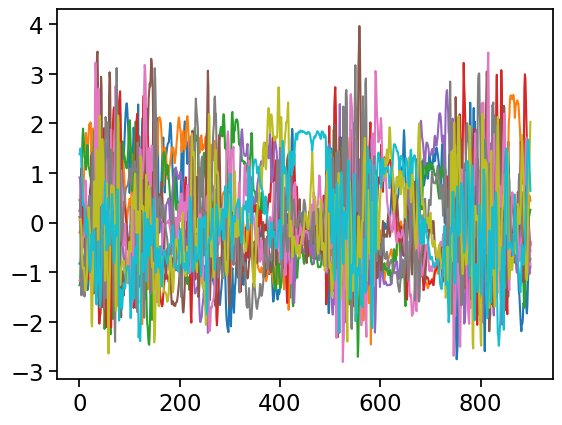

In [146]:
s = scaler.fit_transform(Y.T).shape

plt.plot(scaler.fit_transform(Y.T))

0
1
2
3
4
5
6
7
8
Mean Squared Error: 1.0068415740801044


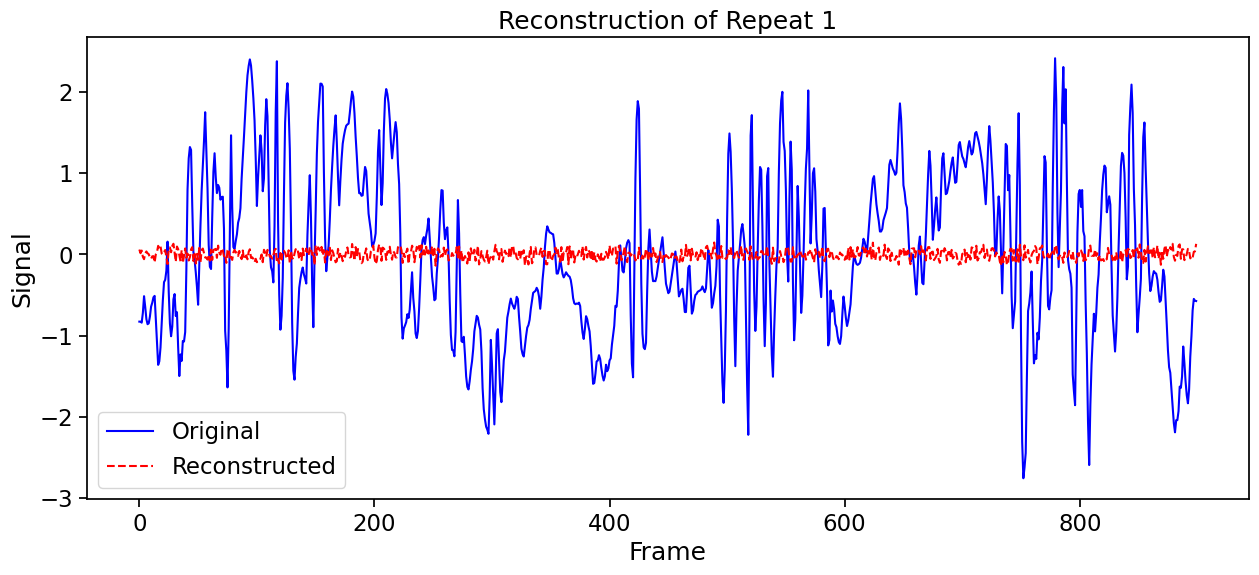

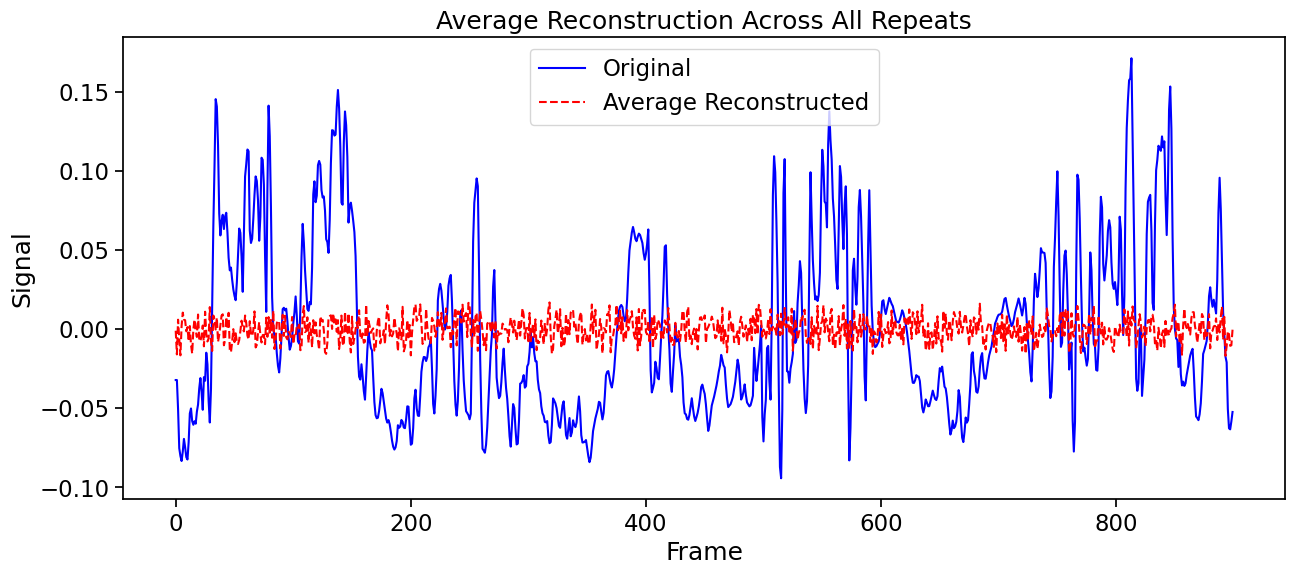

In [150]:
# Initialize the model
model = LinearRegression()

# Store predictions for each repeat
predictions = np.zeros_like(Y)

# standard scale Y
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y.T).T
Y = Y_scaled

# Perform Leave-One-Repeat-Out cross-validation
for i in range(Y.shape[0]-1):
    print(i)
    # Leave the i-th repeat out
    X_train = X.T
    Y_train = np.delete(Y, i, axis=0)
    
    # Prepare test data
    Y_test = Y[i]
    
    # Fit the model on the training data
    model.fit(X_train, Y_train.T)
    
    # Predict on the test data
    Y_pred = model.predict(X.T).T
    
    # Store the prediction for the left-out repeat
    predictions[i] = Y_pred[i]

# Calculate the mean squared error
mse = mean_squared_error(Y.flatten(), predictions.flatten())
print(f'Mean Squared Error: {mse}')

# Average predictions across all iterations
average_prediction = np.mean(predictions, axis=0)

# Plot the original and averaged reconstructed time series for one repeat (e.g., the first repeat)
repeat_index = 0

plt.figure(figsize=(15, 6))
plt.plot(Y[repeat_index], label='Original', color='blue')
plt.plot(predictions[repeat_index], label='Reconstructed', color='red', linestyle='--')
plt.title(f'Reconstruction of Repeat {repeat_index + 1}')
plt.xlabel('Frame')
plt.ylabel('Signal')
plt.legend()
plt.show()

# Plot the average reconstruction over all repeats
plt.figure(figsize=(15, 6))
plt.plot(np.mean(Y, axis=0), label='Original', color='blue')
plt.plot(average_prediction, label='Average Reconstructed', color='red', linestyle='--')
plt.title('Average Reconstruction Across All Repeats')
plt.xlabel('Frame')
plt.ylabel('Signal')
plt.legend()
plt.show()

## Plot predicted vs actual activity

Cross validated score: [-1.19991152e+00  6.15585137e-02 -1.20620457e+00 -1.37268982e+02
 -2.20969139e-01]


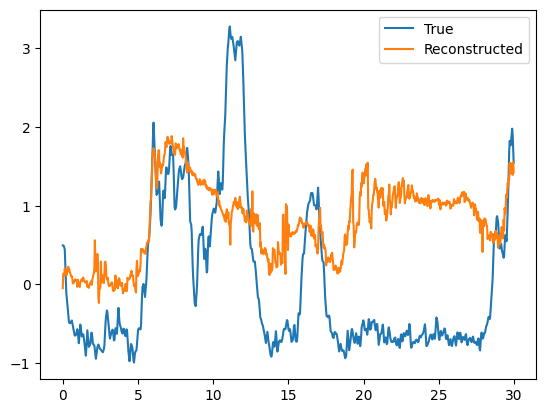

In [336]:

cell_index = 4
y = zscore(cell_mean_traces[cell_index])

model_0 = cell_models[cell_index][1]

# plot reconstructed trace
reconstructed = model_0.predict(X)
plt.plot(trace_timebase, y, label='True')
plt.plot(trace_timebase, reconstructed, label='Reconstructed')
plt.legend()

print(f"Cross validated score: {cell_cross_scores[cell_index]}")

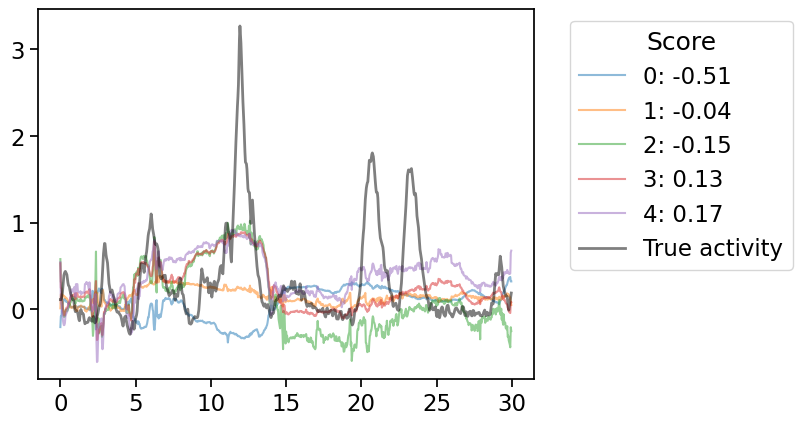

In [80]:
cell_index = 0

for i in range(5):
    y = cell_mean_traces[cell_index]
    model_0 = cell_models[cell_index][i]

    reconstructed = model_0.predict(X)
    
    plt.plot(trace_timebase, reconstructed, label=f"{i}: {np.round(model_0.score(X, y),2)}", alpha=0.5)
    

plt.plot(trace_timebase, y, label='True activity', linewidth=2, alpha=0.5, color='black')
# lgened outside 
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')

# Crop movie to try different features

In [238]:
# get shape of movie frame
movie.shape

(900, 304, 608)

In [83]:
# crop 100 pixel box around center
crop_size = 100
center = movie.shape[1] // 2
movie_cropped = movie[:, center-crop_size:center+crop_size, center-crop_size:center+crop_size]
movie_cropped.shape


(900, 200, 200)

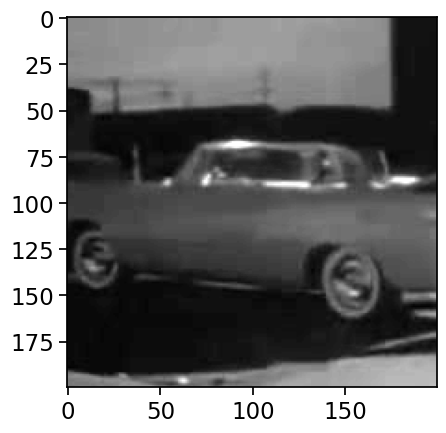

In [84]:
# plot frame of cropped movie
plt.imshow(movie_cropped[350], cmap='gray')


In [94]:
# calc metrics for cropped movie
motion_energy_crop, avg_crop, contrast_crop, kurtosis_crop = calc_movie_metrics(movie_cropped)
me_filtered_crop = signal.medfilt(motion_energy_crop, kernel_size=7)

In [95]:
X_crop = np.vstack([me_filtered_crop, avg_crop, contrast_crop, kurtosis_crop]).T

# us min max scaler to build X
scaler = MinMaxScaler()
X_crop = scaler.fit_transform(X)

In [96]:

# pick cell for Y
# cell_index = 0 
# y = zscore(cell_mean_traces[cell_index])

for cell in range(cell_mean_traces.shape[0]):
    y = cell_mean_traces[cell]
    score, models, _, _ = crossValidateLinearModel(X_crop, y, shuffle=False)
    print(score)

-2.3673103378510083
-6.051325386902567
-2.4899609071410302
-0.045452581322358944
-11.137937990852945


In [97]:
for cell in range(cell_mean_traces.shape[0]):
    y = cell_mean_traces[cell]
    score, models, _, _ = crossValidateLinearModel(X_crop, y, shuffle=True)
    print(score)

0.1518189960289002
0.2807498579675838
0.24632138853811295
0.22113009740579265
0.40131057282158356
